# Предсказание температуры стали на последнем этапе обработки.

## Техническое задание

Чтобы оптимизировать производственные расходы, металлургическому комбинату необходимо уменьшить потребление электроэнергии на этапе обработки стали. Нам предстоит построить модель, которая предскажет температуру стали. Зная температуру стали в зависимости от количества использованный ресурсов, можно будет управлять ею и снизить её там, где сталь нагревается достаточно для формирования слябов, но слишком сильно превышает пороговые показатели, на чём можно было бы сэкономить.

### План работы:  
- Провести исследовательский анализ данных:
    - Посмотреть на распределение исходных данных
    - Заменить выбросы в некоторых признаках медианой
    - Исключить партии, которые не имеют последнего замера темпиратуры, либо первый замер соответствует последнему, либо замеры отсутствуют 
    - Оставить только события, которые находятся в промежутке между первым и последним замерами
- Подобрать признаки, на которых будет обучаться модель:
    - Сгенерировать ряд признаков
    - Проверить признаки на мультиколлинеарность, исключить лишние
    - Провести масштабирование признаков
- Построить модель, которая предскажет температуру стали:
    - Сформировать обучающую, валидационную и тестовую выборки
    - Выбрать несколько моделей и проверить их эффективность на валидационной выборке с помощью показателя эффективности MAE
    - Подобрать параметры моделей для улучшения скора на валидационной выборке
    - Эффективность лучшей модели проверить на тестовой выборке

В ходе работы использованы библиотеки pandas, mtplotlib, datetime, sklearn, catboost, lightgbm. Посмтроены модели машинного обучения CatBoost и LGBM, результаты сравниваются также с работой простейшей нейронной сети. Ключевая метрика - MAE. Подбор наилучших параметров модели проведён с помощью Optuna.

## Подготовка данных

Импортируем модули, которые нам понадобятся для дальнейшей работы.

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import datetime
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_absolute_error
import optuna

import warnings
warnings.simplefilter('ignore')

Читаем базы данных

In [ ]:
arc = pd.read_csv('/datasets/final_steel/data_arc.csv', sep= ',')
bulk = pd.read_csv('/datasets/final_steel/data_bulk.csv', sep= ',')
bulk_time = pd.read_csv('/datasets/final_steel/data_bulk_time.csv', sep= ',')
gas = pd.read_csv('/datasets/final_steel/data_gas.csv', sep= ',')
temp = pd.read_csv('/datasets/final_steel/data_temp.csv', sep= ',')
wire = pd.read_csv('/datasets/final_steel/data_wire.csv', sep= ',')
time = pd.read_csv('/datasets/final_steel/data_wire_time.csv', sep= ',')

for i in [arc, bulk, bulk_time, gas, temp, wire, time]:
    display(i.head().T)
    i.info()

,0,1,2,3,4
key,1,1,1,1,1
Начало нагрева дугой,2019-05-03 11:02:14,2019-05-03 11:07:28,2019-05-03 11:11:44,2019-05-03 11:18:14,2019-05-03 11:26:09
Конец нагрева дугой,2019-05-03 11:06:02,2019-05-03 11:10:33,2019-05-03 11:14:36,2019-05-03 11:24:19,2019-05-03 11:28:37
Активная мощность,0.976059,0.805607,0.744363,1.659363,0.692755
Реактивная мощность,0.687084,0.520285,0.498805,1.062669,0.414397


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   key                   14876 non-null  int64  
 1   Начало нагрева дугой  14876 non-null  object 
 2   Конец нагрева дугой   14876 non-null  object 
 3   Активная мощность     14876 non-null  float64
 4   Реактивная мощность   14876 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB


,0,1,2,3,4
key,1.0,2.0,3.0,4.0,5.0
Bulk 1,NaN,NaN,NaN,NaN,NaN
Bulk 2,NaN,NaN,NaN,NaN,NaN
Bulk 3,NaN,NaN,NaN,NaN,NaN
Bulk 4,43.0,73.0,34.0,81.0,78.0
Bulk 5,NaN,NaN,NaN,NaN,NaN
Bulk 6,NaN,NaN,NaN,NaN,NaN
Bulk 7,NaN,NaN,NaN,NaN,NaN
Bulk 8,NaN,NaN,NaN,NaN,NaN
Bulk 9,NaN,NaN,NaN,NaN,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     float64
 6   Bulk 6   576 non-null    float64
 7   Bulk 7   25 non-null     float64
 8   Bulk 8   1 non-null      float64
 9   Bulk 9   19 non-null     float64
 10  Bulk 10  176 non-null    float64
 11  Bulk 11  177 non-null    float64
 12  Bulk 12  2450 non-null   float64
 13  Bulk 13  18 non-null     float64
 14  Bulk 14  2806 non-null   float64
 15  Bulk 15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB


,0,1,2,3,4
key,1,2,3,4,5
Bulk 1,NaN,NaN,NaN,NaN,NaN
Bulk 2,NaN,NaN,NaN,NaN,NaN
Bulk 3,NaN,NaN,NaN,NaN,NaN
Bulk 4,2019-05-03 11:21:30,2019-05-03 11:46:38,2019-05-03 12:31:06,2019-05-03 12:48:43,2019-05-03 13:18:50
Bulk 5,NaN,NaN,NaN,NaN,NaN
Bulk 6,NaN,NaN,NaN,NaN,NaN
Bulk 7,NaN,NaN,NaN,NaN,NaN
Bulk 8,NaN,NaN,NaN,NaN,NaN
Bulk 9,NaN,NaN,NaN,NaN,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   key      3129 non-null   int64 
 1   Bulk 1   252 non-null    object
 2   Bulk 2   22 non-null     object
 3   Bulk 3   1298 non-null   object
 4   Bulk 4   1014 non-null   object
 5   Bulk 5   77 non-null     object
 6   Bulk 6   576 non-null    object
 7   Bulk 7   25 non-null     object
 8   Bulk 8   1 non-null      object
 9   Bulk 9   19 non-null     object
 10  Bulk 10  176 non-null    object
 11  Bulk 11  177 non-null    object
 12  Bulk 12  2450 non-null   object
 13  Bulk 13  18 non-null     object
 14  Bulk 14  2806 non-null   object
 15  Bulk 15  2248 non-null   object
dtypes: int64(1), object(15)
memory usage: 391.2+ KB


,0,1,2,3,4
key,1.000000,2.000000,3.000000,4.000000,5.000000
Газ 1,29.749986,12.555561,28.554793,18.841219,5.413692


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   Газ 1   3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB


,0,1,2,3,4
key,1,1,1,1,1
Время замера,2019-05-03 11:16:18,2019-05-03 11:25:53,2019-05-03 11:29:11,2019-05-03 11:30:01,2019-05-03 11:30:39
Температура,1571.0,1604.0,1618.0,1601.0,1613.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15907 entries, 0 to 15906
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   key           15907 non-null  int64  
 1   Время замера  15907 non-null  object 
 2   Температура   13006 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 372.9+ KB


,0,1,2,3,4
key,1.000000,2.000000,3.000000,4.000000,5.000000
Wire 1,60.059998,96.052315,91.160157,89.063515,89.238236
Wire 2,NaN,NaN,NaN,NaN,9.114560
Wire 3,NaN,NaN,NaN,NaN,NaN
Wire 4,NaN,NaN,NaN,NaN,NaN
Wire 5,NaN,NaN,NaN,NaN,NaN
Wire 6,NaN,NaN,NaN,NaN,NaN
Wire 7,NaN,NaN,NaN,NaN,NaN
Wire 8,NaN,NaN,NaN,NaN,NaN
Wire 9,NaN,NaN,NaN,NaN,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   float64
 3   Wire 3  63 non-null     float64
 4   Wire 4  14 non-null     float64
 5   Wire 5  1 non-null      float64
 6   Wire 6  73 non-null     float64
 7   Wire 7  11 non-null     float64
 8   Wire 8  19 non-null     float64
 9   Wire 9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


,0,1,2,3,4
key,1,2,3,4,5
Wire 1,2019-05-03 11:11:41,2019-05-03 11:46:10,2019-05-03 12:13:47,2019-05-03 12:48:05,2019-05-03 13:18:15
Wire 2,NaN,NaN,NaN,NaN,2019-05-03 13:32:06
Wire 3,NaN,NaN,NaN,NaN,NaN
Wire 4,NaN,NaN,NaN,NaN,NaN
Wire 5,NaN,NaN,NaN,NaN,NaN
Wire 6,NaN,NaN,NaN,NaN,NaN
Wire 7,NaN,NaN,NaN,NaN,NaN
Wire 8,NaN,NaN,NaN,NaN,NaN
Wire 9,NaN,NaN,NaN,NaN,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   key     3081 non-null   int64 
 1   Wire 1  3055 non-null   object
 2   Wire 2  1079 non-null   object
 3   Wire 3  63 non-null     object
 4   Wire 4  14 non-null     object
 5   Wire 5  1 non-null      object
 6   Wire 6  73 non-null     object
 7   Wire 7  11 non-null     object
 8   Wire 8  19 non-null     object
 9   Wire 9  29 non-null     object
dtypes: int64(1), object(9)
memory usage: 240.8+ KB


Мы получили базу данных из 7 таблиц, в каждой из которых от 2 до 16 признаков. Таблицы объединяются по полю key, что соответствует порядковому номеру партии. Каждая партия проходила от 1 до 15 (в среднем 5) повторных циклов обработки, пока температура не достигалась требуемой. Всего в базе есть данные о 3 129 партиях сырья, которые переплавляли в сталь. Посмотрим на данные каждой таблицы более пристально.

### Таблица с данными об электродах
Каждый раз каждая партия нагревалась от 11 секунд до 15 минут. Информации об ошибочных и стандартных значениях данного показателя не найдено, поэтому по данному признаку удалять данные из базы мы не будем. Столбец с суммарной длительностью нагрева партии можно добавить в итоговую таблицу, на основании которой будет прогнозироваться температура.

In [ ]:
arc['Конец нагрева дугой'] = pd.to_datetime(arc['Конец нагрева дугой'])
arc['Начало нагрева дугой'] = pd.to_datetime(arc['Начало нагрева дугой'])

arc['time_heating'] = arc['Конец нагрева дугой']-arc['Начало нагрева дугой']
arc['time_heating'] = arc['time_heating'].dt.total_seconds().div(60).astype(int)
arc['time_heating'].describe()

count    14876.000000
mean         2.425988
std          1.660323
min          0.000000
25%          1.000000
50%          2.000000
75%          3.000000
max         15.000000
Name: time_heating, dtype: float64

Также нам понадобится суммарная мощность, равная квадратному корню из суммы квадратов активной и реактивной мощности. Посмотрим на переменную реактивной мощности:

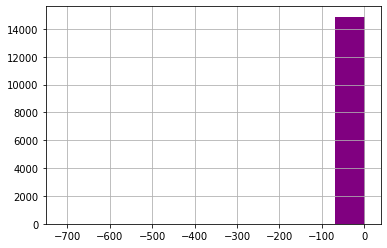

In [ ]:
arc['Реактивная мощность'].hist(color = 'purple')
plt.show()

В левой части есть выброс:

In [ ]:
arc['Реактивная мощность'].describe()

count    14876.000000
mean         0.452592
std          5.878702
min       -715.504924
25%          0.290991
50%          0.415962
75%          0.637371
max          2.676388
Name: Реактивная мощность, dtype: float64

И он только один:

In [ ]:
arc['Реактивная мощность'].sort_values().head(10)

9780   -715.504924
5596      0.020806
2419      0.021154
4914      0.022485
4633      0.022983
676       0.023228
4063      0.023569
6580      0.025329
8704      0.026079
4615      0.026222
Name: Реактивная мощность, dtype: float64

С правой стороны распределение убывание значений происходит плавно, всё в порядке.

In [ ]:
arc['Реактивная мощность'].sort_values(ascending = False).head(10)

7799     2.676388
9226     2.504206
9361     2.459959
12424    2.397032
13760    2.335088
2939     2.236813
14200    2.216230
2661     2.211983
10975    2.197359
7800     2.150657
Name: Реактивная мощность, dtype: float64

Заменим одну запись с отрицательным значением на медиану.

In [ ]:
arc['Реактивная мощность'][9780] = arc['Реактивная мощность'].median()
arc['Реактивная мощность'][9780]

0.41596150395

Далее переменная активной мощности:

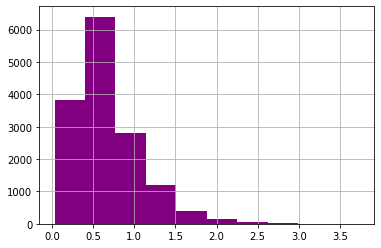

In [ ]:
arc['Активная мощность'].hist(color = 'purple')
plt.show()

Распределение скошено вправо, но несущественно, убирать данные мы не будем.

Рассчитаем общую мощность:

In [ ]:
arc['total_power'] = ((arc['Реактивная мощность'])**2 + (arc['Активная мощность'])**2)**0.5
arc['total_power'].describe()

count    14876.000000
mean         0.838755
std          0.509838
min          0.036664
25%          0.495346
50%          0.694922
75%          1.066649
max          4.592152
Name: total_power, dtype: float64

Суммируем ключевые переменные (время нагрева и суммарную мощность) для каждой партии, подготовив эти переменные для построения модели:

In [ ]:
df = arc[['key', 'time_heating', 'total_power']].groupby(['key']).agg('sum').reset_index()
df

,key,time_heating,total_power
0,1,16,5.826395
1,2,12,3.649216
2,3,9,2.989534
3,4,10,3.814962
4,5,13,4.035758
...,...,...,...
3209,3237,12,4.844982
3210,3238,7,2.696542
3211,3239,16,5.611883
3212,3240,12,3.891856


### Таблица с данными о подаче сыпучих материалов (объём)

In [ ]:
bulk.describe()

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
count,3129.000000,252.000000,22.000000,1298.000000,1014.000000,77.000000,576.000000,25.000000,1.0,19.000000,176.000000,177.000000,2450.000000,18.000000,2806.000000,2248.000000
mean,1624.383509,39.242063,253.045455,113.879045,104.394477,107.025974,118.925347,305.600000,49.0,76.315789,83.284091,76.819209,260.471020,181.111111,170.284747,160.513345
std,933.337642,18.277654,21.180578,75.483494,48.184126,81.790646,72.057776,191.022904,NaN,21.720581,26.060347,59.655365,120.649269,46.088009,65.868652,51.765319
min,1.000000,10.000000,228.000000,6.000000,12.000000,11.000000,17.000000,47.000000,49.0,63.000000,24.000000,8.000000,53.000000,151.000000,16.000000,1.000000
25%,816.000000,27.000000,242.000000,58.000000,72.000000,70.000000,69.750000,155.000000,49.0,66.000000,64.000000,25.000000,204.000000,153.250000,119.000000,105.000000
50%,1622.000000,31.000000,251.500000,97.500000,102.000000,86.000000,100.000000,298.000000,49.0,68.000000,86.500000,64.000000,208.000000,155.500000,151.000000,160.000000
75%,2431.000000,46.000000,257.750000,152.000000,133.000000,132.000000,157.000000,406.000000,49.0,70.500000,102.000000,106.000000,316.000000,203.500000,205.750000,205.000000
max,3241.000000,185.000000,325.000000,454.000000,281.000000,603.000000,503.000000,772.000000,49.0,147.000000,159.000000,313.000000,1849.000000,305.000000,636.000000,405.000000


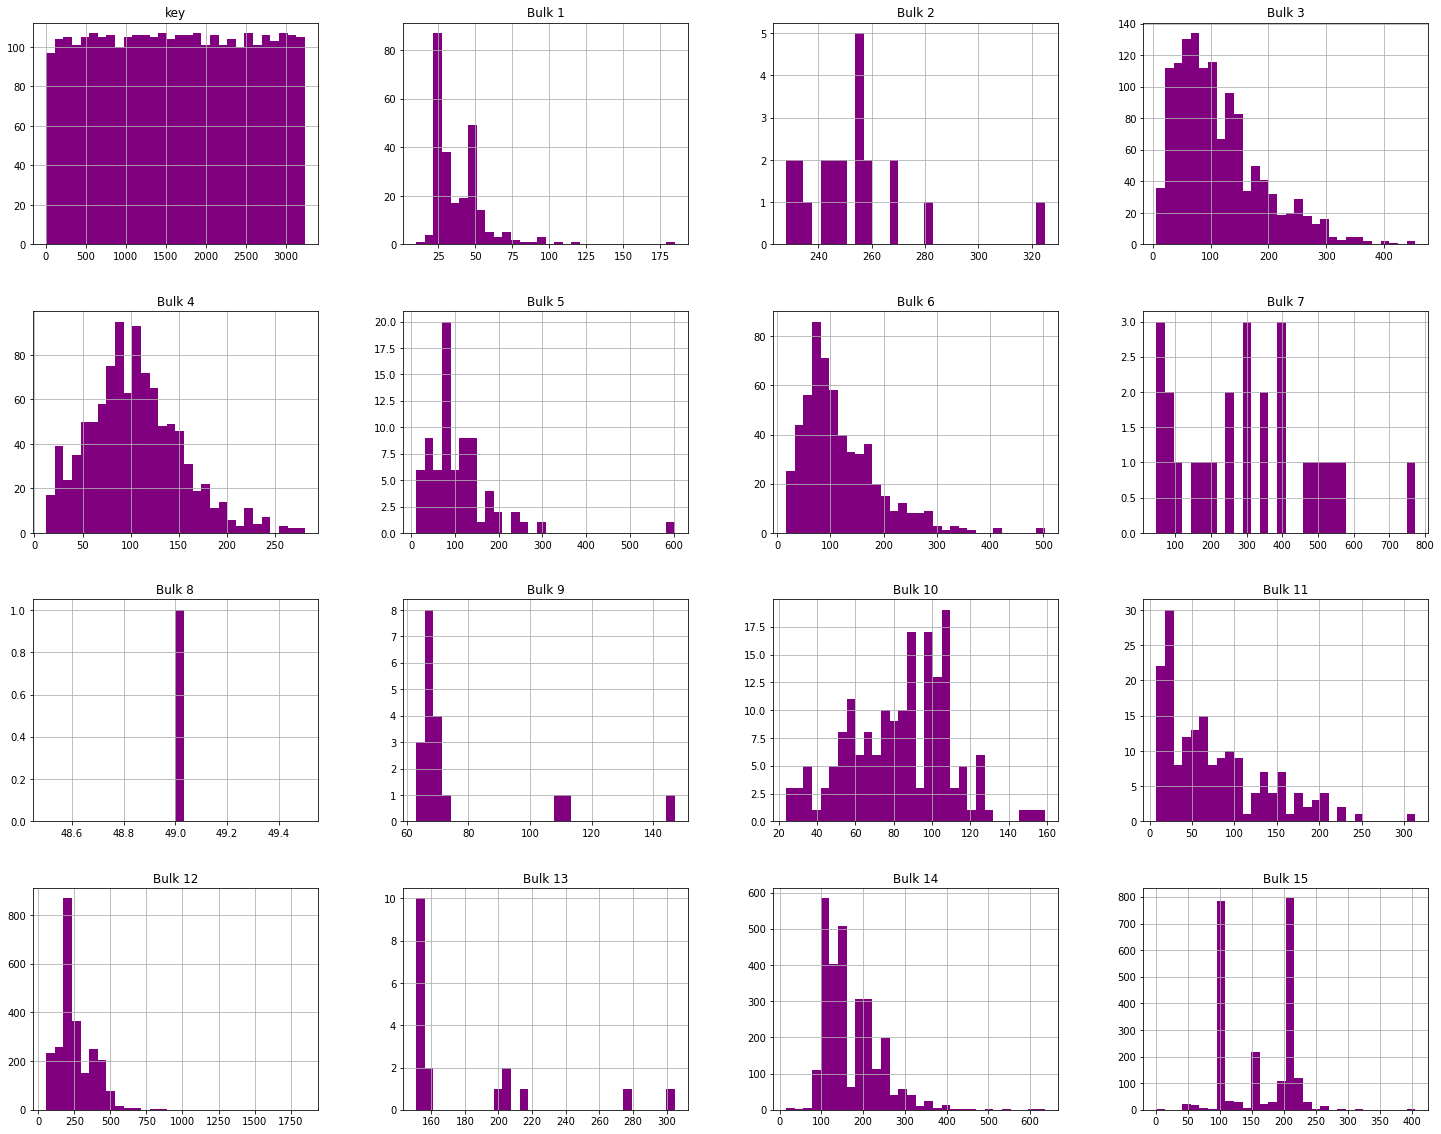

In [ ]:
bulk.hist(bins=30, color = 'Purple', figsize = (25,20))
plt.show()

Согласно полученным данным на производстве ООО «Так закаляем сталь» есть 15 видов присадок, которые добавляют в партию сырья, чтобы получить сталь. Данные у нас разбиты по партиям, не по циклам обработки каждой партии, как в предыдущей таблице.

Каждая присадка добавляется в объёме примерно 50-300 единиц. Есть присадки, используемые в большинстве партий (номер 12, 14, 15), есть используемые в менее чем 1% партий (номер 2, 7, 8, 9, 13), последние мы не будем использовать в итоговой модели. Нам известно, что вариативность самих присадок низкая. Поэтому наряду с признаеами добавления присадок мы будем использовать общую сумму всех добавленных присадок в единицах. И добавим количество присадок от 1 до 15, которые использовались в данной партии.

In [ ]:
bulk['bulk_sum'] = bulk.iloc[:, 1:].sum(axis=1)
bulk['bulk_count'] = bulk.iloc[:, 1:].count(axis=1)

In [ ]:
bulk['bulk_sum'].describe()

count    3129.000000
mean      595.503356
std       276.557794
min        19.000000
25%       429.000000
50%       591.000000
75%       772.000000
max      3235.000000
Name: bulk_sum, dtype: float64

In [ ]:
bulk['bulk_count'].describe()

count    3129.000000
mean        4.566315
std         1.216165
min         2.000000
25%         4.000000
50%         5.000000
75%         5.000000
max         8.000000
Name: bulk_count, dtype: float64

Соединим эти две переменные с итоговой таблицей df, используя номера партий из существующей таблицы df, т.к., если по данной партии нет информации по присадкам, возможно, их не было, но, если нет информации по потребляемой мощности, такой случай для анализа бесполезен.

In [ ]:
df = df.set_index('key').join(bulk[[
    'key',
    'bulk_sum',
    'bulk_count',
    'Bulk 1',
    'Bulk 3',
    'Bulk 4',
    'Bulk 5',
    'Bulk 6',
    'Bulk 10',
    'Bulk 11',
    'Bulk 12',
    'Bulk 14',
    'Bulk 15']].set_index('key'), on='key', how = 'left').reset_index()
df

,key,time_heating,total_power,bulk_sum,bulk_count,Bulk 1,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 10,Bulk 11,Bulk 12,Bulk 14,Bulk 15
0,1,16,5.826395,553.0,5.0,NaN,NaN,43.0,NaN,NaN,NaN,NaN,206.0,150.0,154.0
1,2,12,3.649216,582.0,5.0,NaN,NaN,73.0,NaN,NaN,NaN,NaN,206.0,149.0,154.0
2,3,9,2.989534,544.0,5.0,NaN,NaN,34.0,NaN,NaN,NaN,NaN,205.0,152.0,153.0
3,4,10,3.814962,595.0,5.0,NaN,NaN,81.0,NaN,NaN,NaN,NaN,207.0,153.0,154.0
4,5,13,4.035758,584.0,5.0,NaN,NaN,78.0,NaN,NaN,NaN,NaN,203.0,151.0,152.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3209,3237,12,4.844982,758.0,5.0,NaN,170.0,NaN,NaN,NaN,NaN,NaN,252.0,130.0,206.0
3210,3238,7,2.696542,594.0,5.0,NaN,126.0,NaN,NaN,NaN,NaN,NaN,254.0,108.0,106.0
3211,3239,16,5.611883,630.0,5.0,NaN,NaN,NaN,NaN,114.0,NaN,NaN,158.0,270.0,88.0
3212,3240,12,3.891856,272.0,4.0,NaN,NaN,NaN,NaN,26.0,NaN,NaN,NaN,192.0,54.0


### Данные о продувке сплава газом

In [ ]:
gas.describe()

,key,Газ 1
count,3239.000000,3239.000000
mean,1621.861377,11.002062
std,935.386334,6.220327
min,1.000000,0.008399
25%,812.500000,7.043089
50%,1622.000000,9.836267
75%,2431.500000,13.769915
max,3241.000000,77.995040


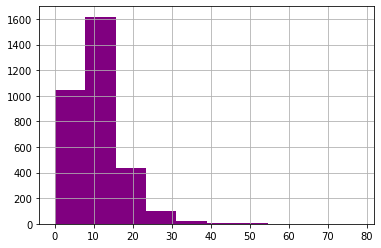

In [ ]:
gas['Газ 1'].hist(color = 'purple')
plt.show()

In [ ]:
gas['Газ 1'].sort_values(ascending = False).head(10)

319     77.995040
277     60.935689
2107    52.142373
2567    51.380229
116     50.581035
2105    45.638999
1461    43.655411
660     41.854643
525     39.728826
610     39.425706
Name: Газ 1, dtype: float64

Всего 8 случаев дают существенный сдвиг "хвоста" распределения вправо, заменим эти выбросы медианой и добавим полученные данные в таблицу, которую мы собираем для формирования модели.

In [ ]:
gas.columns = ['key', 'gas']
gas.loc[(gas['gas'] > 40), 'gas'] = gas['gas'].median()
gas['gas'].sort_values(ascending = False).head(10)

525     39.728826
610     39.425706
2564    39.378164
117     38.982740
1510    38.471706
1878    36.782436
2247    35.769306
1724    35.358709
2265    34.827057
278     34.049878
Name: gas, dtype: float64

In [ ]:
df = df.set_index('key').join(gas.set_index('key'), on='key', how = 'left').reset_index()
df

,key,time_heating,total_power,bulk_sum,bulk_count,Bulk 1,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 10,Bulk 11,Bulk 12,Bulk 14,Bulk 15,gas
0,1,16,5.826395,553.0,5.0,NaN,NaN,43.0,NaN,NaN,NaN,NaN,206.0,150.0,154.0,29.749986
1,2,12,3.649216,582.0,5.0,NaN,NaN,73.0,NaN,NaN,NaN,NaN,206.0,149.0,154.0,12.555561
2,3,9,2.989534,544.0,5.0,NaN,NaN,34.0,NaN,NaN,NaN,NaN,205.0,152.0,153.0,28.554793
3,4,10,3.814962,595.0,5.0,NaN,NaN,81.0,NaN,NaN,NaN,NaN,207.0,153.0,154.0,18.841219
4,5,13,4.035758,584.0,5.0,NaN,NaN,78.0,NaN,NaN,NaN,NaN,203.0,151.0,152.0,5.413692
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3209,3237,12,4.844982,758.0,5.0,NaN,170.0,NaN,NaN,NaN,NaN,NaN,252.0,130.0,206.0,5.543905
3210,3238,7,2.696542,594.0,5.0,NaN,126.0,NaN,NaN,NaN,NaN,NaN,254.0,108.0,106.0,6.745669
3211,3239,16,5.611883,630.0,5.0,NaN,NaN,NaN,NaN,114.0,NaN,NaN,158.0,270.0,88.0,16.023518
3212,3240,12,3.891856,272.0,4.0,NaN,NaN,NaN,NaN,26.0,NaN,NaN,NaN,192.0,54.0,11.863103


### Данные о проволочных материалах (объём)

In [ ]:
wire.describe()

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
count,3081.000000,3055.000000,1079.000000,63.000000,14.000000,1.000,73.000000,11.000000,19.000000,29.000000
mean,1623.426485,100.895853,50.577323,189.482681,57.442841,15.132,48.016974,10.039007,53.625193,34.155752
std,932.996726,42.012518,39.320216,99.513444,28.824667,NaN,33.919845,8.610584,16.881728,19.931616
min,1.000000,1.918800,0.030160,0.144144,24.148801,15.132,0.034320,0.234208,45.076721,4.622800
25%,823.000000,72.115684,20.193680,95.135044,40.807002,15.132,25.053600,6.762756,46.094879,22.058401
50%,1619.000000,100.158234,40.142956,235.194977,45.234282,15.132,42.076324,9.017009,46.279999,30.066399
75%,2434.000000,126.060483,70.227558,276.252014,76.124619,15.132,64.212723,11.886057,48.089603,43.862003
max,3241.000000,330.314424,282.780152,385.008668,113.231044,15.132,180.454575,32.847674,102.762401,90.053604


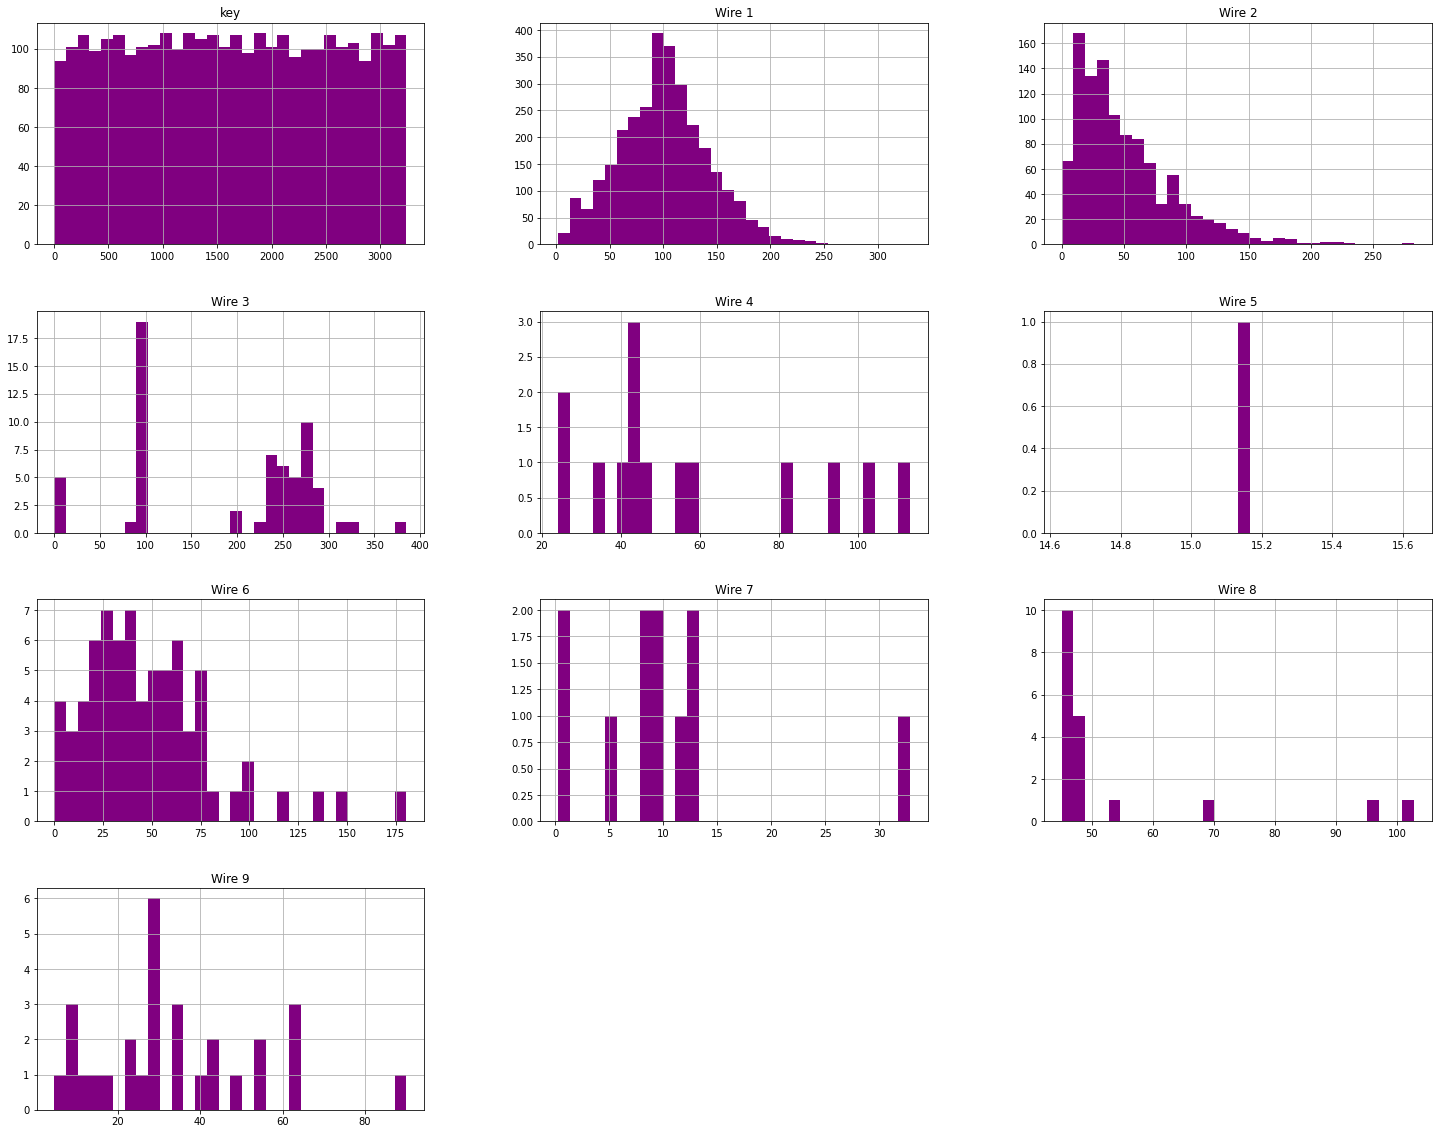

In [ ]:
wire.hist(bins=30, color = 'Purple', figsize = (25,20))
plt.show()

Поступим аналогичным образом, как и с присадками (bulk): суммируем и посчитаем количество используемых проволок. Возьмём только те признаки, которые присутствуют более чем в 1% случаев (исключим проволоки номер 4, 5, 7, 8, 9).

In [ ]:
wire['wire_sum'] = bulk.iloc[:, 1:].sum(axis=1)
wire['wire_count'] = bulk.iloc[:, 1:].count(axis=1)

In [ ]:
wire['wire_sum'].describe()

count    3081.000000
mean     1196.437845
std       554.683622
min        40.000000
25%       863.000000
50%      1186.000000
75%      1553.000000
max      6477.000000
Name: wire_sum, dtype: float64

In [ ]:
wire['wire_count'].describe()

count    3081.000000
mean        5.568971
std         1.217245
min         3.000000
25%         5.000000
50%         6.000000
75%         6.000000
max         9.000000
Name: wire_count, dtype: float64

Соединим полученные переменные с итоговым датафреймом:

In [ ]:
df = df.set_index('key').join(wire[[
    'key',
    'wire_sum',
    'wire_count',
    'Wire 1',
    'Wire 2',
    'Wire 3',
    'Wire 6']].set_index('key'), on='key', how = 'left').reset_index()
df

,key,time_heating,total_power,bulk_sum,bulk_count,Bulk 1,Bulk 3,Bulk 4,Bulk 5,Bulk 6,...,Bulk 12,Bulk 14,Bulk 15,gas,wire_sum,wire_count,Wire 1,Wire 2,Wire 3,Wire 6
0,1,16,5.826395,553.0,5.0,NaN,NaN,43.0,NaN,NaN,...,206.0,150.0,154.0,29.749986,1111.0,6.0,60.059998,NaN,NaN,NaN
1,2,12,3.649216,582.0,5.0,NaN,NaN,73.0,NaN,NaN,...,206.0,149.0,154.0,12.555561,1169.0,6.0,96.052315,NaN,NaN,NaN
2,3,9,2.989534,544.0,5.0,NaN,NaN,34.0,NaN,NaN,...,205.0,152.0,153.0,28.554793,1093.0,6.0,91.160157,NaN,NaN,NaN
3,4,10,3.814962,595.0,5.0,NaN,NaN,81.0,NaN,NaN,...,207.0,153.0,154.0,18.841219,1195.0,6.0,89.063515,NaN,NaN,NaN
4,5,13,4.035758,584.0,5.0,NaN,NaN,78.0,NaN,NaN,...,203.0,151.0,152.0,5.413692,1173.0,6.0,89.238236,9.11456,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3209,3237,12,4.844982,758.0,5.0,NaN,170.0,NaN,NaN,NaN,...,252.0,130.0,206.0,5.543905,1313.0,6.0,38.088959,NaN,NaN,NaN
3210,3238,7,2.696542,594.0,5.0,NaN,126.0,NaN,NaN,NaN,...,254.0,108.0,106.0,6.745669,1757.0,6.0,56.128799,NaN,NaN,NaN
3211,3239,16,5.611883,630.0,5.0,NaN,NaN,NaN,NaN,114.0,...,158.0,270.0,88.0,16.023518,1773.0,6.0,143.357761,NaN,NaN,NaN
3212,3240,12,3.891856,272.0,4.0,NaN,NaN,NaN,NaN,26.0,...,NaN,192.0,54.0,11.863103,1961.0,6.0,34.070400,NaN,NaN,NaN


Т.к. объёмы проволоки и присадок в единицах соизмеримы, добавим переменную общей суммы и общего количества всех добавок:

In [ ]:
df['sum_additions'] = df['wire_sum'] + df['bulk_sum']
df['count_additions'] = df['bulk_count'] + df['wire_count']
df

,key,time_heating,total_power,bulk_sum,bulk_count,Bulk 1,Bulk 3,Bulk 4,Bulk 5,Bulk 6,...,Bulk 15,gas,wire_sum,wire_count,Wire 1,Wire 2,Wire 3,Wire 6,sum_additions,count_additions
0,1,16,5.826395,553.0,5.0,NaN,NaN,43.0,NaN,NaN,...,154.0,29.749986,1111.0,6.0,60.059998,NaN,NaN,NaN,1664.0,11.0
1,2,12,3.649216,582.0,5.0,NaN,NaN,73.0,NaN,NaN,...,154.0,12.555561,1169.0,6.0,96.052315,NaN,NaN,NaN,1751.0,11.0
2,3,9,2.989534,544.0,5.0,NaN,NaN,34.0,NaN,NaN,...,153.0,28.554793,1093.0,6.0,91.160157,NaN,NaN,NaN,1637.0,11.0
3,4,10,3.814962,595.0,5.0,NaN,NaN,81.0,NaN,NaN,...,154.0,18.841219,1195.0,6.0,89.063515,NaN,NaN,NaN,1790.0,11.0
4,5,13,4.035758,584.0,5.0,NaN,NaN,78.0,NaN,NaN,...,152.0,5.413692,1173.0,6.0,89.238236,9.11456,NaN,NaN,1757.0,11.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3209,3237,12,4.844982,758.0,5.0,NaN,170.0,NaN,NaN,NaN,...,206.0,5.543905,1313.0,6.0,38.088959,NaN,NaN,NaN,2071.0,11.0
3210,3238,7,2.696542,594.0,5.0,NaN,126.0,NaN,NaN,NaN,...,106.0,6.745669,1757.0,6.0,56.128799,NaN,NaN,NaN,2351.0,11.0
3211,3239,16,5.611883,630.0,5.0,NaN,NaN,NaN,NaN,114.0,...,88.0,16.023518,1773.0,6.0,143.357761,NaN,NaN,NaN,2403.0,11.0
3212,3240,12,3.891856,272.0,4.0,NaN,NaN,NaN,NaN,26.0,...,54.0,11.863103,1961.0,6.0,34.070400,NaN,NaN,NaN,2233.0,10.0


### Данные о результатах измерения температуры

In [ ]:
temp.describe()

,key,Температура
count,15907.000000,13006.000000
mean,1607.880870,1591.840920
std,942.212073,21.375851
min,1.000000,1191.000000
25%,790.000000,1581.000000
50%,1618.000000,1591.000000
75%,2427.000000,1601.000000
max,3241.000000,1705.000000


Основная переменная анализа - температура на последнем этапе обработки. Минимальная температура плавления стали - не точечное значение. Обычно даётся интервал от 1100 до 1400 градусов. Также у нас нет данных о единицах измерения данной переменной, поэтому удалять случаи из базы мы не будем. Сформируем таблицу с номером партии, первой и последней замеренной температурой.

In [ ]:
temp['Время замера'] = pd.to_datetime(temp['Время замера'])
temp.sort_values(['key', 'Время замера'], ascending=[True, True])

temp_grouped = temp.groupby(['key']).agg({'Время замера': ['min', 'max']}).reset_index()
temp_grouped.columns = ['key', 'first_measurement', 'last_measurement']

temp_grouped = pd.merge(temp_grouped, temp,  how='left', left_on=['key','first_measurement'], right_on = ['key','Время замера'])
temp_grouped.columns = ['key', 'first_measurement', 'last_measurement', 'first_m', 'first_temp']

temp_grouped = pd.merge(temp_grouped, temp,  how='left', left_on=['key','last_measurement'], right_on = ['key','Время замера'])
temp_grouped.columns = ['key', 'first_measurement', 'last_measurement', 'first_m', 'first_temp', 'last_m', 'last_temp']

temp_grouped = temp_grouped[['key', 'first_temp', 'last_temp']]
temp_grouped

,key,first_temp,last_temp
0,1,1571.0,1613.0
1,2,1581.0,1602.0
2,3,1596.0,1599.0
3,4,1601.0,1625.0
4,5,1576.0,1602.0
...,...,...,...
3211,3237,1569.0,NaN
3212,3238,1584.0,NaN
3213,3239,1598.0,NaN
3214,3240,1617.0,NaN


Температура на входе - очень важный параметр (хоть мы берём её и не на действительном входе, а после нескольких итераций, в процессе). Температура на выходе - основная зависимая переменная. Пропуски у нас только в температуре на выходе, но эти данные мы рассчитать не можем, поэтому нам придётся удалить эту существенную часть базы.

In [ ]:
temp_grouped = temp_grouped.dropna()
temp_grouped.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2477 entries, 0 to 2476
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   key         2477 non-null   int64  
 1   first_temp  2477 non-null   float64
 2   last_temp   2477 non-null   float64
dtypes: float64(2), int64(1)
memory usage: 77.4 KB


Соединим сгруппированную по партиям таблицу с df, над которой мы работали ранее.

In [ ]:
df = df.set_index('key').join(temp_grouped.set_index('key'), on='key', how = 'left').reset_index()
df = df.dropna(subset=['last_temp'])
df

,key,time_heating,total_power,bulk_sum,bulk_count,Bulk 1,Bulk 3,Bulk 4,Bulk 5,Bulk 6,...,wire_sum,wire_count,Wire 1,Wire 2,Wire 3,Wire 6,sum_additions,count_additions,first_temp,last_temp
0,1,16,5.826395,553.0,5.0,NaN,NaN,43.0,NaN,NaN,...,1111.0,6.0,60.059998,NaN,NaN,NaN,1664.0,11.0,1571.0,1613.0
1,2,12,3.649216,582.0,5.0,NaN,NaN,73.0,NaN,NaN,...,1169.0,6.0,96.052315,NaN,NaN,NaN,1751.0,11.0,1581.0,1602.0
2,3,9,2.989534,544.0,5.0,NaN,NaN,34.0,NaN,NaN,...,1093.0,6.0,91.160157,NaN,NaN,NaN,1637.0,11.0,1596.0,1599.0
3,4,10,3.814962,595.0,5.0,NaN,NaN,81.0,NaN,NaN,...,1195.0,6.0,89.063515,NaN,NaN,NaN,1790.0,11.0,1601.0,1625.0
4,5,13,4.035758,584.0,5.0,NaN,NaN,78.0,NaN,NaN,...,1173.0,6.0,89.238236,9.11456,NaN,NaN,1757.0,11.0,1576.0,1602.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2470,2495,10,3.986869,719.0,6.0,NaN,21.0,NaN,NaN,NaN,...,989.0,6.0,89.150879,NaN,NaN,NaN,1708.0,12.0,1570.0,1591.0
2471,2496,12,5.057033,796.0,6.0,NaN,NaN,63.0,NaN,NaN,...,1880.0,7.0,114.179527,NaN,NaN,NaN,2676.0,13.0,1554.0,1591.0
2472,2497,8,2.885017,665.0,5.0,NaN,NaN,85.0,NaN,NaN,...,1075.0,6.0,94.086723,9.04800,NaN,NaN,1740.0,11.0,1571.0,1589.0
2473,2498,11,4.143749,733.0,6.0,NaN,90.0,NaN,NaN,NaN,...,850.0,5.0,118.110717,NaN,NaN,NaN,1583.0,11.0,1591.0,1594.0


### Подготовка итоговой таблицы

#### Проверим полученные факторы на мультиколлинеарность.

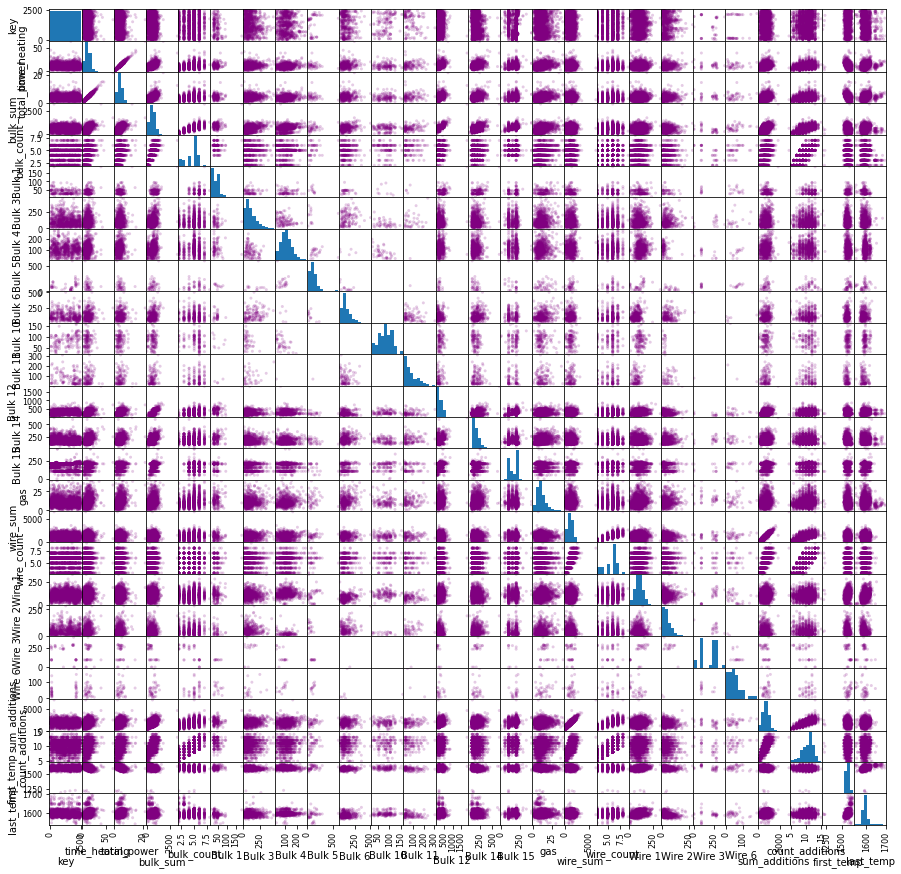

In [ ]:
pd.plotting.scatter_matrix(
    df,
    alpha=0.2,
    color = 'purple',
    figsize = (15, 15))
plt.show()

Мы видим, что можно удалить переменную суммарного времени нагревания, т.к. она имеет те же распределения и высокую корреляцию с затраченной энергией. Аналогично можнопоступить с переменной суммарных добавок, т.к. она повторяет объёмы добавленной проволоки.

In [ ]:
df = df.drop(['time_heating', 'sum_additions'], axis = 1)
df.columns

Index(['key', 'total_power', 'bulk_sum', 'bulk_count', 'Bulk 1', 'Bulk 3',
       'Bulk 4', 'Bulk 5', 'Bulk 6', 'Bulk 10', 'Bulk 11', 'Bulk 12',
       'Bulk 14', 'Bulk 15', 'gas', 'wire_sum', 'wire_count', 'Wire 1',
       'Wire 2', 'Wire 3', 'Wire 6', 'count_additions', 'first_temp',
       'last_temp'],
      dtype='object')

Итак, мы удалили 2 мультиколлинеарных признака, оставив в базе их "оргиналы". Далее мы будем использовать модели градиентного бустинга LightGBM и CatBoost, т.к. они обладают относительно высокой скоростью работы и показывают хорошие результаты, а также они работают с пропусками как с отдельной категорией данных, в нашей базе это важно. Забегая вперёд, можно сказать, что качество модели, если оставить в ней все мультиколлинеарные признаки, при использовании CatBoost ниже. Переменные, обладающие высокой коллинеарностью между собой, по сути дублируют друг друга, а значит модель не может отдать приоритет одному признаку над другим, что снижает качество её работы. Поэтому важно удалять дубликаты таких признаков, оставляя оригиналы. В нашем случае мы оставили по одному признаку из двух пар.

#### Удаление пропусков

Пропуски в прочих переменных (суммарные присадки, добавки проволоки) мы оставим, т.к. у нас нет информации о том, можем ли мы в будущем рассчитывать на получение более полных, чем мы получили базу для анализа, данных. Также мы можем предположить, что отсутствие присадок и добавления проволоки может значить, что их не нужно было добавлять, сырьё изначально было достаточного качества. Т.к. мы будем пользоваться градиентным бустингом catboost, а он автоматически присваивает отдельную категорию пропускам, мы принимаем решение оставить пропуски в базе.

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2475 entries, 0 to 2474
Data columns (total 24 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   key              2475 non-null   int64  
 1   total_power      2475 non-null   float64
 2   bulk_sum         2407 non-null   float64
 3   bulk_count       2407 non-null   float64
 4   Bulk 1           199 non-null    float64
 5   Bulk 3           965 non-null    float64
 6   Bulk 4           814 non-null    float64
 7   Bulk 5           53 non-null     float64
 8   Bulk 6           443 non-null    float64
 9   Bulk 10          143 non-null    float64
 10  Bulk 11          130 non-null    float64
 11  Bulk 12          1882 non-null   float64
 12  Bulk 14          2137 non-null   float64
 13  Bulk 15          1713 non-null   float64
 14  gas              2473 non-null   float64
 15  wire_sum         2372 non-null   float64
 16  wire_count       2372 non-null   float64
 17  Wire 1        

### Вывод

Итак, мы сформировали итоговую таблицу для дальнейшего моделирования процесса и предсказания температуры расплавленной стали на выходе. В итоговой базе для анализа 2475 записей, но есть пропуски. В ходе предобработки мы заменили медианой одно отрицательное значение реактивной мощности, заменили медианой 8 слишком больших значений переменной продувания сплава газом. Удалить пришлось отсутствующие данные по повторным замерам температур, порядка 700 записей.

Также мы сформировали новые переменные для анализа:

Суммарное значение мощности, рассчитанное по формуле
Суммарный объём сыпучих примесей, суммарный объём добавленной проволоки
Количество сыпучих примерей (по количеству заполненных значений переменных bulk от 1 до 15), количество добавленных проволок (по количеству заполненных значений переменных wire от 1 до 9)
Суммарное количество добавок (по количеству, присадки и проволоки)
Первая по счёту температура для данной партии и последняя по счёту
Теперь можно приступать к работе с моделями.

## Предсказание температуры на выходе

Разделим данные на тестовую, валидационную и тренировочную выборки. Нормируем признаки, т.к. они имеют разную размерность.

In [ ]:
X = df.drop(['key','last_temp'], axis=1)
y = df['last_temp']

scaler = StandardScaler()

X_train, X_to_split, y_train, y_to_split = train_test_split(
    X, y, test_size=0.4, random_state=42)

X_valid, X_test, y_valid, y_test = train_test_split(
    X_to_split, y_to_split, test_size=0.5, random_state=42)

X_train, X_valid, X_test = scaler.fit_transform(X_train), scaler.fit_transform(X_valid), scaler.fit_transform(X_test)

print(X.shape, y.shape)
print(X_train.shape, y_train.shape)
print(X_valid.shape, y_valid.shape)
print(X_test.shape, y_test.shape)

(2475, 22) (2475,)
(1485, 22) (1485,)
(495, 22) (495,)
(495, 22) (495,)


In [ ]:
df

,key,total_power,bulk_sum,bulk_count,Bulk 1,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 10,...,gas,wire_sum,wire_count,Wire 1,Wire 2,Wire 3,Wire 6,count_additions,first_temp,last_temp
0,1,5.826395,553.0,5.0,NaN,NaN,43.0,NaN,NaN,NaN,...,29.749986,1111.0,6.0,60.059998,NaN,NaN,NaN,11.0,1571.0,1613.0
1,2,3.649216,582.0,5.0,NaN,NaN,73.0,NaN,NaN,NaN,...,12.555561,1169.0,6.0,96.052315,NaN,NaN,NaN,11.0,1581.0,1602.0
2,3,2.989534,544.0,5.0,NaN,NaN,34.0,NaN,NaN,NaN,...,28.554793,1093.0,6.0,91.160157,NaN,NaN,NaN,11.0,1596.0,1599.0
3,4,3.814962,595.0,5.0,NaN,NaN,81.0,NaN,NaN,NaN,...,18.841219,1195.0,6.0,89.063515,NaN,NaN,NaN,11.0,1601.0,1625.0
4,5,4.035758,584.0,5.0,NaN,NaN,78.0,NaN,NaN,NaN,...,5.413692,1173.0,6.0,89.238236,9.11456,NaN,NaN,11.0,1576.0,1602.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2470,2495,3.986869,719.0,6.0,NaN,21.0,NaN,NaN,NaN,90.0,...,7.125735,989.0,6.0,89.150879,NaN,NaN,NaN,12.0,1570.0,1591.0
2471,2496,5.057033,796.0,6.0,NaN,NaN,63.0,NaN,NaN,122.0,...,9.412616,1880.0,7.0,114.179527,NaN,NaN,NaN,13.0,1554.0,1591.0
2472,2497,2.885017,665.0,5.0,NaN,NaN,85.0,NaN,NaN,NaN,...,6.271699,1075.0,6.0,94.086723,9.04800,NaN,NaN,11.0,1571.0,1589.0
2473,2498,4.143749,733.0,6.0,NaN,90.0,NaN,NaN,NaN,101.0,...,14.953657,850.0,5.0,118.110717,NaN,NaN,NaN,11.0,1591.0,1594.0


### Градиентный бустинг Catboost

In [ ]:
model_cat = CatBoostRegressor(loss_function="RMSE", iterations=90)
model_cat.fit(X_train, y_train, verbose=10)

predictions = model_cat.predict(X_valid)

current_model = pd.DataFrame({'Model': ['Catboost'],
              'MAE, grad': [mean_absolute_error(y_valid, predictions)]})
all_models = current_model.merge(current_model, how = 'outer')
all_models

Learning rate set to 0.308683
0:	learn: 13.7760407	total: 52ms	remaining: 4.63s
10:	learn: 8.1727701	total: 84.6ms	remaining: 607ms
20:	learn: 7.3366460	total: 116ms	remaining: 381ms
30:	learn: 6.7831716	total: 148ms	remaining: 282ms
40:	learn: 6.2833029	total: 180ms	remaining: 215ms
50:	learn: 5.8884091	total: 212ms	remaining: 162ms
60:	learn: 5.6368402	total: 247ms	remaining: 117ms
70:	learn: 5.3275997	total: 279ms	remaining: 74.7ms
80:	learn: 5.0140952	total: 311ms	remaining: 34.6ms
89:	learn: 4.7527897	total: 341ms	remaining: 0us


,Model,"MAE, grad"
0,Catboost,6.376842


Теперь мы можем предсказывать температуру +/- 6 градусов цельсия, что при разбросе от 1200 до 1700 достаточно хорошо. Однако у нас есть задача получить эту мертику меньше 6 градусов.

### Градиентный бустинг LightGBM

In [ ]:
model_lgbm = LGBMRegressor(random_state=23)
model_lgbm.fit(X_train, y_train, eval_set=[(X_valid, y_valid),], eval_metric=["RMSE"])

predictions = model_lgbm.predict(X_valid)

current_model = pd.DataFrame({'Model': ['LightGBM'],
              'MAE, grad': [mean_absolute_error(y_valid, predictions)]})
all_models = all_models.merge(current_model, how = 'outer')
all_models

[1]	valid_0's rmse: 14.7886	valid_0's l2: 218.702
[2]	valid_0's rmse: 14.1395	valid_0's l2: 199.927
[3]	valid_0's rmse: 13.5211	valid_0's l2: 182.82
[4]	valid_0's rmse: 13.0262	valid_0's l2: 169.681
[5]	valid_0's rmse: 12.6129	valid_0's l2: 159.086
[6]	valid_0's rmse: 12.2772	valid_0's l2: 150.73
[7]	valid_0's rmse: 11.9421	valid_0's l2: 142.613
[8]	valid_0's rmse: 11.6647	valid_0's l2: 136.065
[9]	valid_0's rmse: 11.4271	valid_0's l2: 130.579
[10]	valid_0's rmse: 11.1888	valid_0's l2: 125.189
[11]	valid_0's rmse: 11.0138	valid_0's l2: 121.304
[12]	valid_0's rmse: 10.862	valid_0's l2: 117.983
[13]	valid_0's rmse: 10.69	valid_0's l2: 114.275
[14]	valid_0's rmse: 10.5734	valid_0's l2: 111.797
[15]	valid_0's rmse: 10.426	valid_0's l2: 108.702
[16]	valid_0's rmse: 10.3715	valid_0's l2: 107.568
[17]	valid_0's rmse: 10.2561	valid_0's l2: 105.188
[18]	valid_0's rmse: 10.2156	valid_0's l2: 104.359
[19]	valid_0's rmse: 10.1812	valid_0's l2: 103.658
[20]	valid_0's rmse: 10.1088	valid_0's l2: 102

,Model,"MAE, grad"
0,Catboost,6.376842
1,LightGBM,6.709382


Результат тоже неплохой, но CatBoost был лучше.

### Промежуточные выводы и оценка важности факторов

Мы корректно подобрали признаки так, что мы можем предсказать температуру с ошибкой в 6 градусов. При использовании LightGBM шкала важности факторов сложно интерпретируется, а вот при использовании CatBoost мы можем оценить вклад каждого фактора в итоговую температуру на выходе:

In [ ]:
feature_importances = pd.DataFrame({'importance_rate': model_cat.feature_importances_.round(1)}, index = X.columns)
feature_importances.sort_values('importance_rate', ascending = False).head(5)

,importance_rate
first_temp,24.6
wire_count,21.7
total_power,16.3
Wire 1,5.4
gas,3.3


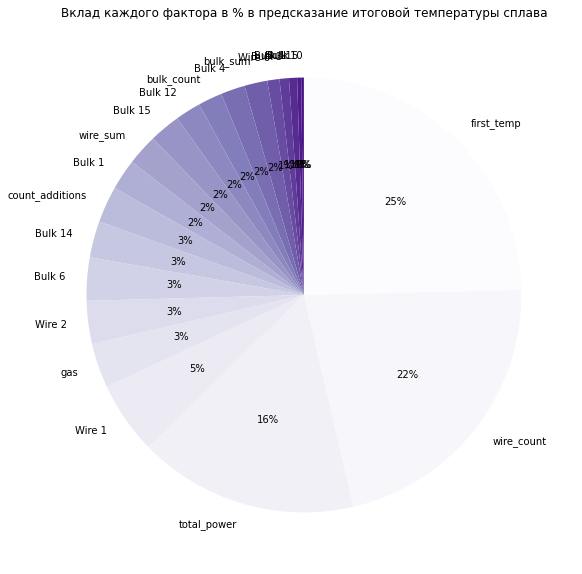

In [ ]:
(feature_importances.sort_values('importance_rate')
 .plot(
     kind='pie',
     y = 'importance_rate',
     x = 'factor',
     figsize=(10, 10),
     autopct='%1.0f%%',
     startangle=90,
     colormap="Purples_r",
     legend=False))


plt.title('Вклад каждого фактора в % в предсказание итоговой температуры сплава')
plt.ylabel('')
plt.show()

Большую часть вклада в прогноз вносит количество добавленных проволок, начальная температура и объём затраченной энергии. Однако значимость прочих признаков убывает плавно. При удалении самых незначимых факторов качество модели не возрастает, поэтому так снизить ключевую метрику (среднюю абсолютную ошибку) не удастся.
Тем не менее, это важный вывод. Если на производстве сложности с замерами на разных этапах, как минимум, нужно знать первоначальную температуру, следить за затраченной мощностью и считать количество добавленных присадок и проволок.

### Подбор параметров моделей для снижения MAE

В ходе исследования был опробован подбор параметров методом GridSearchCV, что принесло небольшое снижение ключевой метрики, однако его использование занимает много ресурсов, поэтому итерировать можно только небольшое количество параметров. Пример кода для CatBoostRegressor:

```python
parameters = {'iterations': [120, 150],
              'depth': [5, 10, 15]}
CBR = CatBoostRegressor(loss_function="RMSE")

Grid_CBR = GridSearchCV(estimator=CBR, param_grid = parameters, cv = 2, n_jobs=-1, scoring='neg_mean_absolute_error')
Grid_CBR.fit(X_train, y_train, verbose=10)
Grid_CBR.best_params_
```

Более широкие возможности предоставляет библиотека Optuna, воспользуемся ею. Ранее мы получили лучшие результаты у градиентного бустинга CatBoost, настроим его параметры:

In [ ]:
def objective(trial):
    
    params = {
        'max_depth': trial.suggest_int('max_depth', 3, 16),
        'learning_rate': trial.suggest_loguniform('learning_rate', 1e-5, 1e0),
        'n_estimators': trial.suggest_int('n_estimators', 70, 8000),
        'max_bin': trial.suggest_int('max_bin', 200, 400),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 1, 300),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 0.0001, 1.0, log = True),
        'colsample_bylevel': trial.suggest_float('colsample_bylevel', 0.01, 0.1),
        'subsample': trial.suggest_float('subsample', 0.1, 0.8),
        'random_seed': 4545,
        'boosting_type': trial.suggest_categorical('boosting_type', ["Ordered", "Plain"]),
        'loss_function': trial.suggest_categorical('loss_function', ["RMSE", "MAE"]),
        'eval_metric': 'RMSE'
    }
    
    model = CatBoostRegressor(**params)  
    model.fit(X_train, y_train, eval_set = [(X_valid,y_valid)], early_stopping_rounds = 200, verbose = False)
    predictions = model.predict(X_valid)
    
    return mean_absolute_error(y_valid, predictions)

study = optuna.create_study(direction = 'minimize')
study.optimize(objective, n_trials = 30)

current_model = pd.DataFrame({'Model': ['Catboost optuned'],
              'MAE, grad': study.best_value})
all_models = all_models.merge(current_model, how = 'outer')
all_models

[I 2022-04-25 06:56:13,018] A new study created in memory with name: no-name-4b244990-56c2-490e-8259-6081fc4b0408
[I 2022-04-25 06:56:18,518] Trial 0 finished with value: 9.625193322292876 and parameters: {'max_depth': 5, 'learning_rate': 0.00010130089388277875, 'n_estimators': 6905, 'max_bin': 248, 'min_data_in_leaf': 70, 'l2_leaf_reg': 0.0005648263653569062, 'colsample_bylevel': 0.01487998671856981, 'subsample': 0.5306680502970784, 'boosting_type': 'Plain', 'loss_function': 'MAE'}. Best is trial 0 with value: 9.625193322292876.
[I 2022-04-25 06:56:22,611] Trial 1 finished with value: 6.431435974516042 and parameters: {'max_depth': 8, 'learning_rate': 0.029380222851624335, 'n_estimators': 4677, 'max_bin': 312, 'min_data_in_leaf': 214, 'l2_leaf_reg': 0.09774104168423044, 'colsample_bylevel': 0.04991127186509515, 'subsample': 0.7428240512327028, 'boosting_type': 'Ordered', 'loss_function': 'RMSE'}. Best is trial 1 with value: 6.431435974516042.
[I 2022-04-25 06:56:25,854] Trial 2 finish

,Model,"MAE, grad"
0,Catboost,6.376842
1,LightGBM,6.709382
2,Catboost optuned,6.336548


Наилучшие параметры мы получили на попытке №15 из 30. Перепишем гиперпараметры CatBoost из этой попытки и посчитаем итоговую среднюю абсолютную ошибку на тестовой выборке.

In [ ]:
model_final = CatBoostRegressor(max_depth = 5,
                           learning_rate = 0.05810886423140443,
                           n_estimators = 6754,
                           max_bin = 294,
                           min_data_in_leaf = 209,
                           l2_leaf_reg = 0.008147374997534622,
                           colsample_bylevel = 0.07779349862851216,
                           subsample = 0.4874562391812446,
                           boosting_type = 'Ordered',
                           loss_function = 'MAE',
                           random_state = 42)
model_final.fit(X_train, y_train, eval_set = [(X_test,y_test)], verbose = False)
predictions = model_final.predict(X_test)
mean_absolute_error(y_test, predictions)

5.863722315789423

### Дополнительная модель: нейронная сеть

Мы добились достаточно точного определения температуры - с погрешностью менее 6 градусов. Посмотрим, удастся ли с помощью нейронной сети добиться лучших результатов. Для начала сгенерируем новый датасет без пропусков:

In [ ]:
df1 = df[['key', 'total_power', 'bulk_sum', 'bulk_count', 'gas', 'wire_sum', 'wire_count', 'count_additions', 'first_temp', 'last_temp']]
df1 = df1.fillna(0)

X = df1.drop(['key','last_temp'], axis=1)
y = df1['last_temp']

scaler = StandardScaler()

X_train, X_to_split, y_train, y_to_split = train_test_split(
    X, y, test_size=0.4, random_state=42)

X_valid, X_test, y_valid, y_test = train_test_split(
    X_to_split, y_to_split, test_size=0.5, random_state=42)

X_train, X_valid, X_test = scaler.fit_transform(X_train), scaler.fit_transform(X_valid), scaler.fit_transform(X_test)

print(X.shape, y.shape)
print(X_train.shape, y_train.shape)
print(X_valid.shape, y_valid.shape)
print(X_test.shape, y_test.shape)

(2475, 8) (2475,)
(1485, 8) (1485,)
(495, 8) (495,)
(495, 8) (495,)


Теперь запустим нейросеть:

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam

model = Sequential()
optimizer_1 = Adam(lr=0.01)

model.add(Dense(64, input_shape=(X_train.shape[1],)))
model.add(Dense(64, activation='relu'))
#model.add(Dense(64, activation='relu'))
model.add(Dense(units=1))
#model.add(Dense(1))

model.compile(optimizer=optimizer_1, loss='mean_absolute_error', metrics=['mean_absolute_error'])

model.fit(X_train, y_train, epochs=1000, batch_size=128, verbose=2)

Epoch 1/1000
12/12 - 0s - loss: 1587.0524 - mean_absolute_error: 1587.0524 - 342ms/epoch - 29ms/step
Epoch 2/1000
12/12 - 0s - loss: 1517.3551 - mean_absolute_error: 1517.3551 - 15ms/epoch - 1ms/step
Epoch 3/1000
12/12 - 0s - loss: 1216.2913 - mean_absolute_error: 1216.2913 - 75ms/epoch - 6ms/step
Epoch 4/1000
12/12 - 0s - loss: 838.6343 - mean_absolute_error: 838.6343 - 15ms/epoch - 1ms/step
Epoch 5/1000
12/12 - 0s - loss: 759.4153 - mean_absolute_error: 759.4153 - 16ms/epoch - 1ms/step
Epoch 6/1000
12/12 - 0s - loss: 638.2263 - mean_absolute_error: 638.2263 - 76ms/epoch - 6ms/step
Epoch 7/1000
12/12 - 0s - loss: 483.9026 - mean_absolute_error: 483.9026 - 16ms/epoch - 1ms/step
Epoch 8/1000
12/12 - 0s - loss: 297.0450 - mean_absolute_error: 297.0450 - 77ms/epoch - 6ms/step
Epoch 9/1000
12/12 - 0s - loss: 153.1258 - mean_absolute_error: 153.1258 - 15ms/epoch - 1ms/step
Epoch 10/1000
12/12 - 0s - loss: 61.6944 - mean_absolute_error: 61.6944 - 76ms/epoch - 6ms/step
Epoch 11/1000
12/12 - 0

In [ ]:
predictions = model.predict(X_test)
mean_absolute_error(y_test, predictions)

9.461995196101642

Качество данной модели оказалось ниже, погрешность возросла до 9 градусов. Поэтому наилучший результат остаётся у градиентного бустинга CatBoost.

## Вывод о результате работы модели

Мы создали модель предсказания температуры расплавленной стали для ООО "Так закаляем сталь". Наилучший вариант - градиентный бустинг  CatBoost, с помощью которого удалось добиться ключевой метрики MAE (средней абсолютной ошибки) на уровне менее 6 градусов.

Большую часть вклада в прогноз вносит количество и суммарный объём добавленных проволок, начальная температура и объём затраченной энергии. Если на производстве сложности с замерами на разных этапах, как минимум, нужно знать первоначальную температуру, следить за затраченной мощностью и считать количество добавленных присадок и проволок.

## Вывод о результатах проекта в целом

<font color='green'><br> **Какие пункты плана были выполнены, а какие — нет (поясните почему)?**
<font color='black'><br> Выполнены все пункты плана, приведённого в п.1.1 данной работы. Помимо этого, план дополнен дополнительной моделью - нейронной сетью, которая не подтвердила гипотезу о лучшем качестве модели. Лучшие результаты показал catboost.
    
<font color='green'><br> **Какие трудности возникли и как вы их преодолели?**
<font color='black'><br> Основная сложность была в формировании итоговой таблицы, на основании которой была построена модель. Если опираться на достижение цели по минимизации MAE, то здесь небольшой размер базы определил ряд негативных побочных эффектов: при повторном разбиении выборки на трейн, тест и валидацию или при повторном построении моделей при указании другого значения random state можно было получить разницу MAE в 1 градус. С другой стороны, когда речь идёт о температурах в несколько тысяч градусов, когда сама температура плавления и перехода в другие агрегатные состояния указывается диапазоном, разница в 1 градус может быть списана на погрешность измерения. Поэтому достижение целевого скора слабо соотносится с характером предоставленных данных. Стоит обратить внимание заказчика скорее не на способности модели, а на сами признаки, на которые необходимо обращать внимание, чтобы избежать перенагрева сплава.
    
    
<font color='green'><br> **Какие ключевые шаги в решении задачи выделили?**
<font color='black'><br> 

    1. Найти целевой признак, определить понятие одного случая для целевого признака.
    2. Сформировать аналитическую таблицу по принятым случаям:
        2.1. Отобрать случаи
        2.2. Присвоить им значения имеющихся в базе признаков
        2.3. Создать новые признаки из имеющихся, присвоить их случаям
        2.4. Сократить признаки (убрать мультиколлинеарные, незначимые)
    3. Построить модели, сравнить их по ключевой метрике, выбрать и оптимизировать модель
    4. Рассчитать итоговое значение на тестовой выборке, описать результат, дать рекомендации бизнесу
    
<font color='green'><br> **Какая ваша итоговая модель и какое у неё качество?**
<font color='black'><br> Наилучший результат показал градиентный бустинг CatBoost. Качество итоговой модели позволяет предсказывать температуру сплава на последнем этапе по имеющимся в базе признакам с погрешностью менее 6 градусов Цельсия.